### 1. Dataset download and optimization

In [1]:
import os
import shutil
import numpy as np
from PIL import Image

if not os.path.isdir('dataset-splitted'):

  #Download dataset from google drive

  #Positive
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=15RkLfTQNknZPNOVRL60yDyht9sNdyUCP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=15RkLfTQNknZPNOVRL60yDyht9sNdyUCP" -O positiveFinal.zip && rm -rf /tmp/cookies.txt
  #Negative
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hdjnMDhlDK8gCaRLM6bDxs2Uz6Q-A4Mn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hdjnMDhlDK8gCaRLM6bDxs2Uz6Q-A4Mn" -O negativeFinal.zip && rm -rf /tmp/cookies.txt

  #Prepare unzip and prepare dataset folder

  folder_path = r'datasetLarge'
  positive_zip = "positiveFinal.zip"
  negative_zip = "negativeFinal.zip"
  positive = "positive"
  negative = "negative"
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

  shutil.unpack_archive(positive_zip, folder_path)
  shutil.unpack_archive(negative_zip, folder_path)

  os.remove(positive_zip)
  os.remove(negative_zip)
  os.rename(folder_path+'/positiveFinal',folder_path+'/'+positive)
  os.rename(folder_path+'/negativeFinal',folder_path+'/'+negative)

  def optimize_positive(folder_path, threshold=0.8, central_ratio=0.5):
      count = 0
      color_rgba = [0, 0, 4, 255]  # Color to check

      for filename in os.listdir(folder_path):
          if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
              file_path = os.path.join(folder_path, filename)
              try:
                  image = Image.open(file_path)
                  mode = image.mode
                  width, height = 312,312
                  # Calculate the region of interest
                  central_width = int(width * central_ratio)
                  central_height = int(height * central_ratio)
                  left = (width - central_width) // 2
                  top = (height - central_height) // 2
                  right = left + central_width
                  bottom = top + central_height
                  # Crop the image to the central region
                  cropped_image = image.crop((left, top, right, bottom))
                  np_image = np.array(cropped_image)
                  color_pixels = np.sum(np.all(np_image == color_rgba, axis=-1))
                  total_pixels = central_width * central_height
                  color_ratio = color_pixels / total_pixels
                  if color_ratio <= threshold:
                      os.remove(file_path)
                      count = count+1
              except (IOError, OSError):
                  print(f"Failed to open image: {file_path}")
      return count

  def optimize_negative(folder_path, threshold=0.9, central_ratio=0.5):
      count = 0
      color_rgba = [0, 0, 4, 255]  # Color to check

      for filename in os.listdir(folder_path):
          if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
              file_path = os.path.join(folder_path, filename)
              try:
                  image = Image.open(file_path)
                  mode = image.mode
                  width, height = 312,312
                  # Calculate the region of interest
                  central_width = int(width * central_ratio)
                  central_height = int(height * central_ratio)
                  left = (width - central_width) // 2
                  top = (height - central_height) // 2
                  right = left + central_width
                  bottom = top + central_height
                  # Crop the image to the central region
                  cropped_image = image.crop((left, top, right, bottom))
                  np_image = np.array(cropped_image)
                  color_pixels = np.sum(np.all(np_image == color_rgba, axis=-1))

                  total_pixels = central_width * central_height

                  color_ratio = color_pixels / total_pixels
                  if color_ratio >= threshold:
                      os.remove(file_path)
                      count = count+1
              except (IOError, OSError):
                  print(f"Failed to open image: {file_path}")
      return count


  print("Optimizes negatives: "+ str(optimize_negative(folder_path+'/'+negative)))
  print("Optimized positives: "+ str(optimize_positive(folder_path+'/'+positive)))

--2023-07-26 20:25:22--  https://docs.google.com/uc?export=download&confirm=t&id=15RkLfTQNknZPNOVRL60yDyht9sNdyUCP
Resolving docs.google.com (docs.google.com)... 74.125.130.101, 74.125.130.139, 74.125.130.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.130.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pf1ii6jmqhgeihoapap2dqco5ug0m4dl/1690403100000/08588315227229181520/*/15RkLfTQNknZPNOVRL60yDyht9sNdyUCP?e=download&uuid=54bbf614-6fea-46e9-80a6-825275c90bba [following]
--2023-07-26 20:25:23--  https://doc-08-9k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pf1ii6jmqhgeihoapap2dqco5ug0m4dl/1690403100000/08588315227229181520/*/15RkLfTQNknZPNOVRL60yDyht9sNdyUCP?e=download&uuid=54bbf614-6fea-46e9-80a6-825275c90bba
Resolving doc-08-9k-docs.googleusercontent.com (doc-08-9k-docs.googleusercontent.com)... 74.125.130.132, 

### 2. Imports and requirements

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.applications import VGG19

In [3]:
!pip install split-folders

In [4]:
import splitfolders
import os
path = "datasetLarge"
print(os.listdir(path))

splitfolders.ratio(path,seed=1337, output="dataset-splitted", ratio=(0.6,0.2,0.2))

['positive', 'negative']


Copying files: 18932 files [00:03, 5066.38 files/s]


In [5]:
OUTPUT_DIR = ''
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

### 3. Dataset split and preparation

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory
dir="dataset-splitted"
train_dataset = image_dataset_from_directory(
    directory= dir+"/train",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
     color_mode='rgb')
validation_dataset = image_dataset_from_directory(
    directory= dir+ "/val",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
     color_mode='rgb',
    batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(
    directory=  dir+"/test",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
     color_mode='rgb',
    batch_size=BATCH_SIZE)

Found 11358 files belonging to 2 classes.
Found 3785 files belonging to 2 classes.
Found 3789 files belonging to 2 classes.


In [7]:
# Prepare datasets for modelling
def prepare(ds, augment=False):
    # Define transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    # Apply rescale to the datasets
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(validation_dataset, augment=False)
test_dataset = prepare(test_dataset, augment=False)

### 4. Network creation and training

In [8]:
from tensorflow.keras.applications import VGG19
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.utils import np_utils

conv_base= VGG19(weights="imagenet",include_top=False,input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
conv_base.trainable=False

model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(2,activation='sigmoid'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=2e-4),
    metrics=['accuracy']
)

# Implement early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(train_dataset, epochs=100, batch_size=32,validation_data=valid_dataset,callbacks=[early_stopping])

80134624/80134624 [==============================] - 5s 0us/step
Epoch 1/100
355/355 [==============================] - 52s 113ms/step - loss: 0.2190 - accuracy: 0.9085 - val_loss: 0.1475 - val_accuracy: 0.9403
Epoch 2/100
355/355 [==============================] - 39s 107ms/step - loss: 0.1238 - accuracy: 0.9554 - val_loss: 0.1898 - val_accuracy: 0.9192
Epoch 3/100
355/355 [==============================] - 40s 112ms/step - loss: 0.1189 - accuracy: 0.9541 - val_loss: 0.1468 - val_accuracy: 0.9413
Epoch 4/100
355/355 [==============================] - 40s 110ms/step - loss: 0.1061 - accuracy: 0.9589 - val_loss: 0.1094 - val_accuracy: 0.9564
Epoch 5/100
355/355 [==============================] - 40s 111ms/step - loss: 0.0924 - accuracy: 0.9645 - val_loss: 0.1113 - val_accuracy: 0.9556
Epoch 6/100
355/355 [==============================] - 40s 111ms/step - loss: 0.0979 - accuracy: 0.9611 - val_loss: 0.1122 - val_accuracy: 0.9554
Epoch 7/100
355/355 [==============================] - 40s 

### 5. Loss and accuracy curves

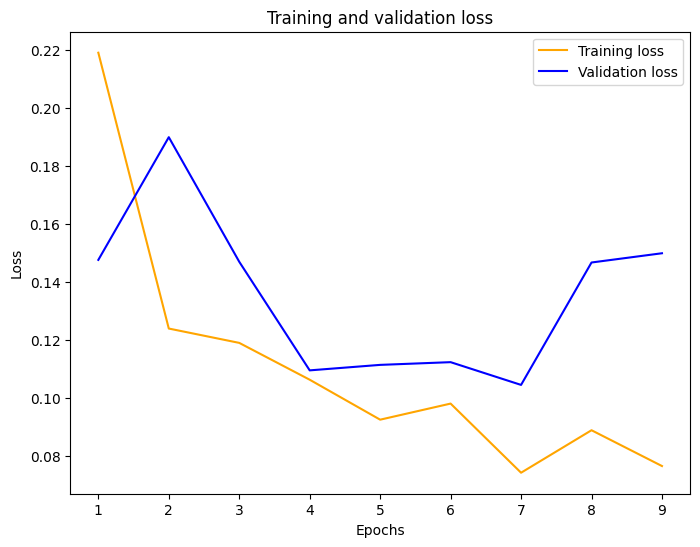

In [9]:
# Plot the loss curves for training and validation.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

fig = plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'orange', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig('loss.png', dpi=fig.dpi)

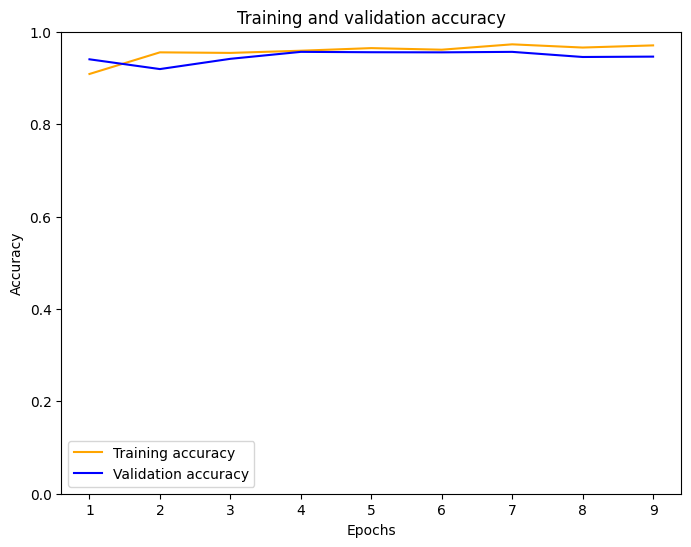

In [10]:
# Plot the accuracy curves for training and validation.
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(acc_values)+1)

fig = plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'orange', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()
fig.savefig('accuracy.png', dpi=fig.dpi)

### 6. Model test and evaluation

In [11]:
# Compute the final loss and accuracy
result = model.evaluate(test_dataset, verbose=0)
print("EVALUATION Final loss: {0:.6f}, final accuracy: {1:.6f}".format(result[0], result[1]))

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score


# Predict probabilities using the model
predictions = []
true_labels = []

for images, labels in test_dataset:
    predictions_batch = model.predict(images, verbose = 0)
    predictions.extend(predictions_batch)
    true_labels.extend(labels.numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Compute the final loss using the true labels and predicted probabilities
final_loss = np.mean(
    tf.keras.losses.sparse_categorical_crossentropy(true_labels, predictions).numpy()
)

# Calculate accuracy by comparing predicted labels with true labels
predicted_labels = np.argmax(predictions, axis=1)
accuracy = np.mean(predicted_labels == true_labels)

final_precision_score = precision_score(true_labels,predicted_labels)
print("PRECISION: {0:.6f}".format(final_precision_score))
final_recall = recall_score(true_labels,predicted_labels)
print("RECALL: {0:.6f}".format(final_recall))
final_f1_score = f1_score(true_labels,predicted_labels)
print("F1 SCORE: {0:.6f}".format(final_f1_score))
final_roc_auc_score = roc_auc_score(true_labels,predicted_labels)
print("ROC AUC: {0:.6f}".format(final_roc_auc_score))
final_avg_prec_score = average_precision_score(true_labels,predicted_labels)
print("Average precision score: {0:.6f}".format(final_avg_prec_score))

EVALUATION Final loss: 0.106829, final accuracy: 0.963843
PRECISION: 0.964637
RECALL: 0.967965
F1 SCORE: 0.966298
ROC AUC: 0.963528
Average precision score: 0.950889


In [ ]:
# save maodel
model.save("model150Imagenet/")
import shutil
shutil.make_archive('model150Imagenet','zip',
                    '',
                    'model150Imagenet')

'/content/model150Imagenet.zip'

### Accuracy by class

In [12]:
positive_labels = true_labels == 1
negative_labels = true_labels == 0

positive_predictions = predictions[positive_labels]
positive_true_labels = true_labels[positive_labels]
positive_predicted_labels = np.argmax(positive_predictions, axis=1)
positive_accuracy = np.mean(positive_predicted_labels == positive_true_labels)


negative_predictions = predictions[negative_labels]
negative_true_labels = true_labels[negative_labels]
negative_predicted_labels = np.argmax(negative_predictions, axis=1)
negative_accuracy = np.mean(negative_predicted_labels == negative_true_labels)

overall_accuracy = np.mean(predicted_labels == true_labels)

print("Positive Label Accuracy:", positive_accuracy)
print("Negative Label Accuracy:", negative_accuracy)
print("Overall Accuracy:", overall_accuracy)

Positive Label Accuracy: 0.9679645145391819
Negative Label Accuracy: 0.9590909090909091
Overall Accuracy: 0.9638427025600422
